# Introduction

Here we are finalising the information that we would like to gather from the molecules db. Specifically, we would want tabled information for each ingredient, containing the proportions of molecules for each ingredient.

# Overview

Getting this finalised dataset entails:

- Selecting from duplicate content entries (selecting orig_foods)
- Averaging from duplicate content entries
- Aggregating final dataset

# Setup

In [32]:
#|default_exp molecule.finalise

In [33]:
#| export
from pyprojroot import here
root = here()
import sys
sys.path.append(str(root))

In [34]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

from recipe_dataset.molecule.match import *
from recipe_dataset.density.food_match import *

from functools import reduce

import pickle

In [35]:
#| export
pd.options.mode.chained_assignment = None  # default='warn'

In [36]:
ingredients_df = pd.read_feather('../../data/local/recipe/partial/ingredients/0.feather')
expanded_ingredients_df = pd.read_feather('../../data/local/recipe/partial/expanded_ingredients/0.feather')
food_df = pd.read_feather('../../data/local/molecule/full/food/1_processed.feather')
content_df = pd.read_feather('../../data/local/molecule/full/content/1_processed.feather')
compound_df = pd.read_feather('../../data/local/molecule/full/compound/1_processed.feather')

# Averaging Duplicate Content Values

Here we have entries of each compound measurement - measured in a standardised concentration of mg/100g. What we want to form is a table of the foods, with features for the concentration of each chemical compound. 

### Handling NA's

#### Content DF

The NA measuremnets coming from this dataset we have already established as seen compounds, but without having thier concentrations measured. How do we deal with this numerically?

Since they are registered as being seen, we should have a (>0) value for them. What makes the most sense is to use the total mean of this value.

#### Expanded DF

Since the data here comes from various sources, there is not a standardised set of measured compounds, so not all foods will have the full featureset. These NA's can be filled as 0, as there was no study which registered them as being present.

In [37]:
content_df['concentration'].notnull().sum() / content_df.index.get_level_values(1).nunique()

9.853602148709754

In [38]:
mean_source_concentrations = content_df.groupby('source_id').apply(lambda item: item['concentration'].mean(skipna=True))
mean_source_concentrations

source_id
4            0.38438
13          1.223154
14        535.347763
24          0.113715
25          0.902589
             ...    
139984          <NA>
139985          <NA>
139986          <NA>
139987          <NA>
139988          <NA>
Length: 58826, dtype: object

Filtering compounds without any measured values.

In [39]:
content_df = content_df.loc[~content_df.index.get_level_values(1).isin(mean_source_concentrations.index[mean_source_concentrations.isna()])]

In [40]:
mean_source_concentrations = content_df.groupby('source_id').apply(lambda item: item['concentration'].mean(skipna=True))
assert mean_source_concentrations.isna().sum() == 0

In [41]:
content_df = content_df.reset_index(0)
content_df['concentration'] = content_df['concentration'].fillna(mean_source_concentrations)
content_df = content_df.reset_index().set_index(['food_id', 'source_id'])

## Formatting

In [42]:
food_compounds_df = pd.pivot_table(content_df, index='food_id', columns='source_id', values='concentration', aggfunc='mean', fill_value=pd.NA)
food_compounds_df

source_id,4,13,14,24,25,27,31,35,40,41,...,125217,125218,125219,125220,125221,125222,125223,125225,125226,125227
food_id,,,,,,,,,,,,,,,,,,,,,
0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1157,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1158,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


# Feature Engineering

Here we have a large number of features (ie. compound datapoints) which could be filtered. 

## Handling Nulls

The filter criteria here are how many datapoints they contain. 

### Rows

In [43]:
notna = food_compounds_df.notna().sum(axis=1)
notna

food_id
0       333
1       449
2       428
3        75
4       337
       ... 
1156     98
1157    183
1158    141
1159      1
1160      2
Length: 1161, dtype: int64

Removing foods with low compound measurements.

In [44]:
notna = food_compounds_df.notna().sum(axis=1)
notna

food_id
0       333
1       449
2       428
3        75
4       337
       ... 
1156     98
1157    183
1158    141
1159      1
1160      2
Length: 1161, dtype: int64

In [45]:
notna.mean(), notna.std()

(172.49698535745048, 151.38414324859454)

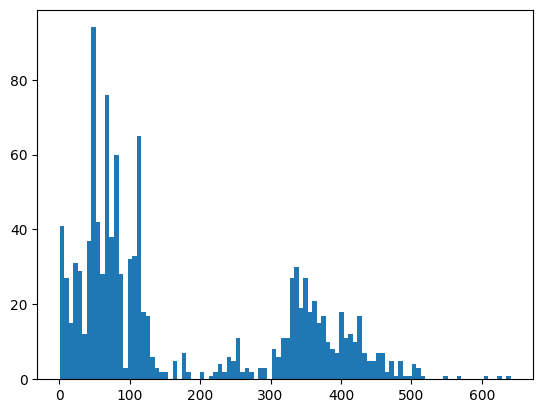

In [46]:
plt.hist(notna, bins=100);

There are still many foods with near 0 compound information. Which foods are they?

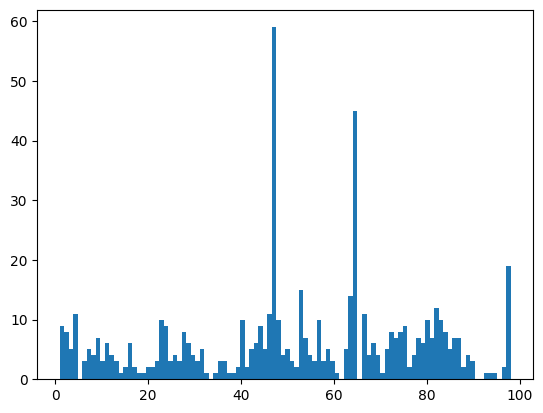

In [47]:
plt.hist(notna[notna<100], bins=100);

In [48]:
notna[notna < 10].to_frame('contents_count').join(food_df['name'])['name']

food_id
13        dried lemon verbena
33                   cook oat
124           dried sweet bay
199             cook purslane
219                 cook pear
228        dried blackcurrant
239         dried common sage
252            dried eggplant
385                     bison
386          alaska blackfish
393                 wild boar
400                   buffalo
404      cook giant butterbur
434            nuttall cockle
467                       elk
468                       emu
477          dried ginkgo nut
478             greylag goose
484                guinea hen
491                     horse
512            leather chiton
522               dried lotus
541                  tunicate
546     dried pacific herring
549               velvet duck
550                  pheasant
598              sea cucumber
624                     squab
680            pacific salmon
713              dried walrus
801                berry wine
886              cocoa liquor
898                 cook tofu
94

It's good to see these are simply just obscure ingredients, which can quite easily be removed.

In [49]:
food_compounds_df = food_compounds_df[(notna > 10) | food_compounds_df.index.isin([1025, 1026])]
food_compounds_df.shape

(1106, 1746)

### Columns

Removing compounds with low total appearances.

In [50]:
notna_cols = food_compounds_df.notna().sum(axis=0)
notna_cols

source_id
4         2
13        1
14        4
24        2
25        2
         ..
125222    2
125223    2
125225    2
125226    2
125227    3
Length: 1746, dtype: int64

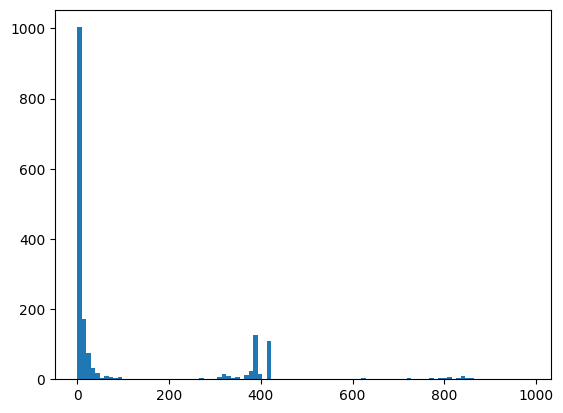

In [51]:
plt.hist(notna_cols, bins=100);

In [52]:
notna_cols.index[notna_cols<10].shape

(1003,)

In [53]:
food_compounds_df.loc[:, (notna_cols>300)].shape

(1106, 408)

In [55]:
food_compounds_df = food_compounds_df.loc[:, (notna_cols>300)]
food_compounds_df.shape

(1106, 408)

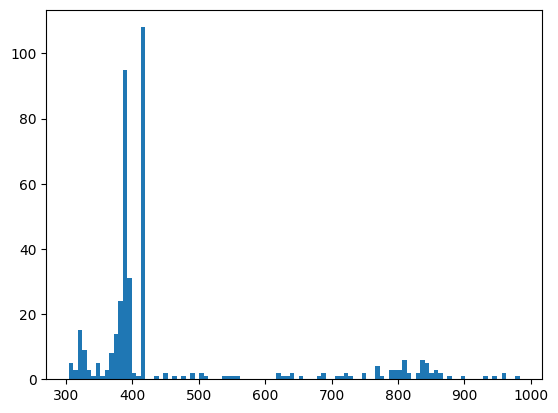

In [58]:
plt.hist((food_compounds_df.notna()).sum(axis=0), bins=100);

## Filtering Zeros

We kept zeros separate here because they do have information ie. does not contain this compound rather than not been studied. 

However ultimatley our model will require continious inputs, in which case the NA's will need to be handled. The best assumption that could be made here are that the unmeasured compounds are zero.

In this case, we repeat the above process to filter the samples/features that are all (or mostly) zero.

In [74]:
food_compounds_df = food_compounds_df.fillna(0)

### Rows

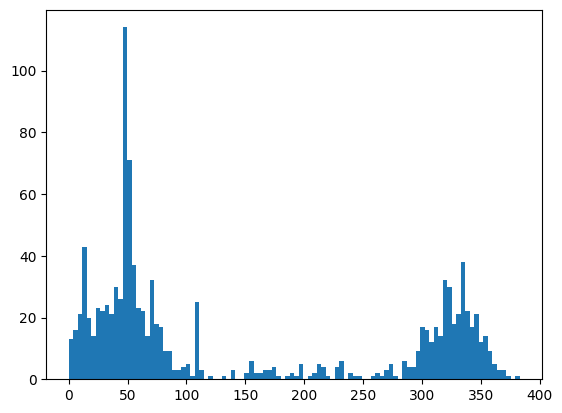

In [79]:
nonzero = (food_compounds_df > 0).sum(1)
plt.hist(nonzero, bins=100);

In [80]:
nonzero[nonzero < 100]

food_id
3       52
6       14
7       12
9       14
11       5
        ..
1115    42
1130    63
1131    47
1135    36
1156    15
Length: 649, dtype: Int64

In [81]:
food_df['name'].loc[nonzero[nonzero < 100].index]

food_id
3         cook allium
6           cook leek
7          dried leek
9        dried garlic
11        dried chive
            ...      
1115       white wine
1130             clam
1131        cook clam
1135    cook plantain
1156         fish oil
Name: name, Length: 649, dtype: string

This might not be a good idea, because there in fact are many foods which don't contain many compounds yet are still vital to a recipe (ie. baking soda, salt, etc.)

### Columns

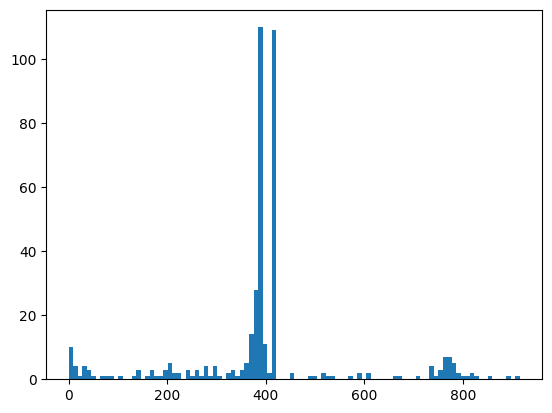

In [83]:
nonzero = (food_compounds_df > 0).sum(0)
plt.hist(nonzero, bins=100);

There are still a number of compounds here which are only contained in a subset of foods.

## Converting

These above are using the weight concentration ratio measured in mg/100g.

# Syncing DFs

Applying filters to all dataframes.

In [85]:
food_df = food_df.loc[food_compounds_df.index]
food_df

,base_food_id,name,name_scientific,description,wikipedia_id,food_group,food_subgroup,food_type,category,n_content
food_id,,,,,,,,,,
0,1,angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,Angelica,Herbs and Spices,Herbs,Type 1,specific,5609
1,4,kiwi,Actinidia chinensis,"The kiwifruit, often shortened to kiwi in many...",Kiwifruit,Fruits,Tropical fruits,Type 1,specific,5987
2,5,allium,Allium,Allium haematochiton is a species of wild onio...,Allium haematochiton,Vegetables,Onion-family vegetables,Type 1,specific,7668
3,5,cook allium,Allium,Allium haematochiton is a species of wild onio...,Allium haematochiton,Vegetables,Onion-family vegetables,Type 1,specific,7668
4,6,garden onion,Allium cepa,The onion (Allium cepa) (Latin 'cepa' = onion)...,Onion,Vegetables,Onion-family vegetables,Type 1,specific,14791
...,...,...,...,...,...,...,...,...,...,...
1154,1019,white bread,<NA>,White bread typically refers to breads made fr...,<NA>,Cereals and cereal products,Cereals,Type 1,<NA>,5714
1155,1021,herbal tea,<NA>,Herbal teas are the beverages made from the in...,<NA>,Teas,Teas,Type 1,<NA>,6643
1156,1022,fish oil,<NA>,Fish oil is oil derived from the tissues of oi...,<NA>,None,<NA>,Type 1,<NA>,154


Resetting id's to make them sequential.

In [86]:
food_df = food_df.sort_index().reset_index().drop(['food_id'], axis=1).rename_axis('id')
food_df

,base_food_id,name,name_scientific,description,wikipedia_id,food_group,food_subgroup,food_type,category,n_content
id,,,,,,,,,,
0,1,angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,Angelica,Herbs and Spices,Herbs,Type 1,specific,5609
1,4,kiwi,Actinidia chinensis,"The kiwifruit, often shortened to kiwi in many...",Kiwifruit,Fruits,Tropical fruits,Type 1,specific,5987
2,5,allium,Allium,Allium haematochiton is a species of wild onio...,Allium haematochiton,Vegetables,Onion-family vegetables,Type 1,specific,7668
3,5,cook allium,Allium,Allium haematochiton is a species of wild onio...,Allium haematochiton,Vegetables,Onion-family vegetables,Type 1,specific,7668
4,6,garden onion,Allium cepa,The onion (Allium cepa) (Latin 'cepa' = onion)...,Onion,Vegetables,Onion-family vegetables,Type 1,specific,14791
...,...,...,...,...,...,...,...,...,...,...
1101,1019,white bread,<NA>,White bread typically refers to breads made fr...,<NA>,Cereals and cereal products,Cereals,Type 1,<NA>,5714
1102,1021,herbal tea,<NA>,Herbal teas are the beverages made from the in...,<NA>,Teas,Teas,Type 1,<NA>,6643
1103,1022,fish oil,<NA>,Fish oil is oil derived from the tissues of oi...,<NA>,None,<NA>,Type 1,<NA>,154


In [87]:
food_compounds_df = food_compounds_df.sort_index().reset_index().drop(['food_id'], axis=1).rename_axis('id')
food_compounds_df

source_id,236,316,446,455,465,474,484,556,565,567,...,121976,122105,122117,122183,122207,122257,122370,122486,122510,123210
id,,,,,,,,,,,,,,,,,,,,,
0,0.109333,1.386966,422.779168,0.0,0.0,998.946623,651.838176,727.187833,0.930556,0.662912,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
1,0.109333,1.386966,28.75,0.0,50.0,57.666667,51.5,45.25,0.578571,0.662912,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
2,0.109333,1.386966,59.25,0.0,86.25,122.5625,96.1,79.35,0.474375,0.662912,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
3,0.0,0.0,23.666667,0.0,21.666667,45.0,39.333333,26.333333,0.006667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.109333,1.386966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.532184,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,0.0,0.0,257.529412,0.0,410.125,272.125,308.705882,308.0,0.275455,0.0,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
1102,0.109333,1.386966,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.662912,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
1103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
assert len(food_compounds_df) == len(food_df)

In [92]:
import seaborn as sns

<Axes: xlabel='236', ylabel='Count'>

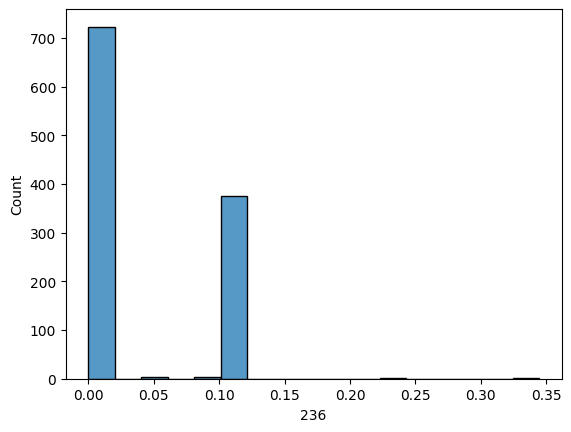

In [93]:
sns.histplot(food_compounds_df.iloc[:,0])

<Axes: ylabel='Count'>

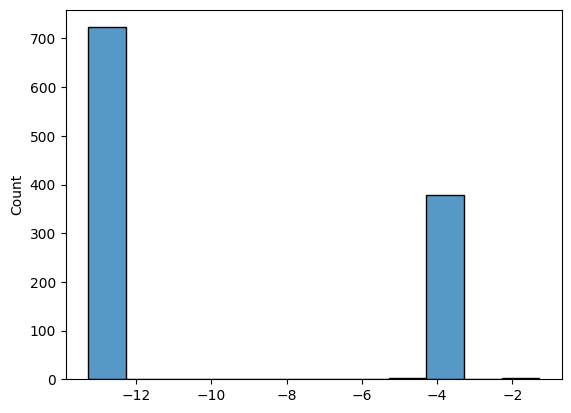

In [109]:
from scipy.stats import boxcox
normalized = boxcox(food_compounds_df.iloc[:,0]+0.01, lmbda=-0.4)
sns.histplot(normalized)

# Saving

In [110]:
food_compounds_df

source_id,236,316,446,455,465,474,484,556,565,567,...,121976,122105,122117,122183,122207,122257,122370,122486,122510,123210
id,,,,,,,,,,,,,,,,,,,,,
0,0.109333,1.386966,422.779168,0.0,0.0,998.946623,651.838176,727.187833,0.930556,0.662912,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
1,0.109333,1.386966,28.75,0.0,50.0,57.666667,51.5,45.25,0.578571,0.662912,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
2,0.109333,1.386966,59.25,0.0,86.25,122.5625,96.1,79.35,0.474375,0.662912,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
3,0.0,0.0,23.666667,0.0,21.666667,45.0,39.333333,26.333333,0.006667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.109333,1.386966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.532184,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,0.0,0.0,257.529412,0.0,410.125,272.125,308.705882,308.0,0.275455,0.0,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
1102,0.109333,1.386966,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.662912,...,2.253628,2.253628,2.253628,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016
1103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
food_compounds_df.to_feather('../../data/local/molecule/full/food_compounds/0.feather')
food_compounds_df.shape

(1106, 408)

In [112]:
food_df.to_feather('../../data/local/molecule/full/food/2_feature_engineered.feather')
food_df.shape

(1106, 10)